In [50]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam

from keras.layers import BatchNormalization

from tqdm import tqdm

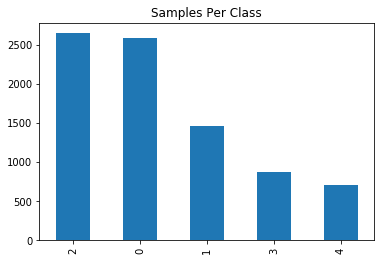

In [65]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)


frac_drop = {"2019": [0.7, 0.1, 0.4], "2015": [0.9, 0.4, 0.5]}
class_to_val = [[0.85, 0.1, 0.05, 0, 0],
                [0.1, 0.8, 0.1, 0, 0],
                [0, 0.15, 0.7, 0.15, 0],
                [0, 0, 0.1, 0.8, 0.1], 
                [0, 0, 0.05, 0.1, 0.85]]

def getDF(year="2019", dataset="train"):
    
    # take in data, remap images, standardise data
    if (year == "2019"):
        df         = pd.read_csv(f"../aptos2019/{dataset}.csv") 
        df.id_code = df.id_code.apply(lambda x: x + ".png")
    elif (year == "2015"):
        df       = pd.read_csv("../aptos2015/trainLabels.csv") 
        df.image = df.image.apply(lambda x: x + ".jpeg")
        
        df["id_code"]   = df.image
        df["diagnosis"] = df.level
    else:
        print("not implemented")
        exit()
        
    # if test, we're done
    if dataset == "test":
        return df
    
    # shuffle data so each time different samples are dropped
    df = df.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    for i in range(5):
        df[str(i)] = df.diagnosis.apply(lambda x: class_to_val[x][i])

    df.diagnosis = df.diagnosis.astype('str')

    # get rid of a lot of the more common classes
    for diagnosis in range(3):
        indexes = df[df['diagnosis'] == str(diagnosis)].index
        df.drop(indexes[:int(frac_drop[year][diagnosis]*indexes.size)], inplace=True)

    # shuffle it for even distribution later
    df = df.sample(frac=1)
    
    return df

# plot example
df_to_plot = getDF(year="2015")
df_to_plot['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');

In [66]:
# Global constants
IMG_DIM      = 300
BATCH_SIZE   = 24
CHANNEL_SIZE = 3
ZOOM         = 0.8

df_train = getDF()
df_test  = getDF(dataset="test")
df_train_2015 = getDF(year="2015")

NUM_CLASSES = df_train['diagnosis'].nunique()

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

df_train.columns, df_test.columns, NUM_CLASSES


(Index(['id_code', 'diagnosis', '0', '1', '2', '3', '4'], dtype='object'),
 Index(['id_code'], dtype='object'),
 5)

In [6]:
# assumes RGB
def colourfulEyes(img):
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, 3, cv2.GaussianBlur(y, (0,0), 60),-3, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
    
    return rgb_modified 

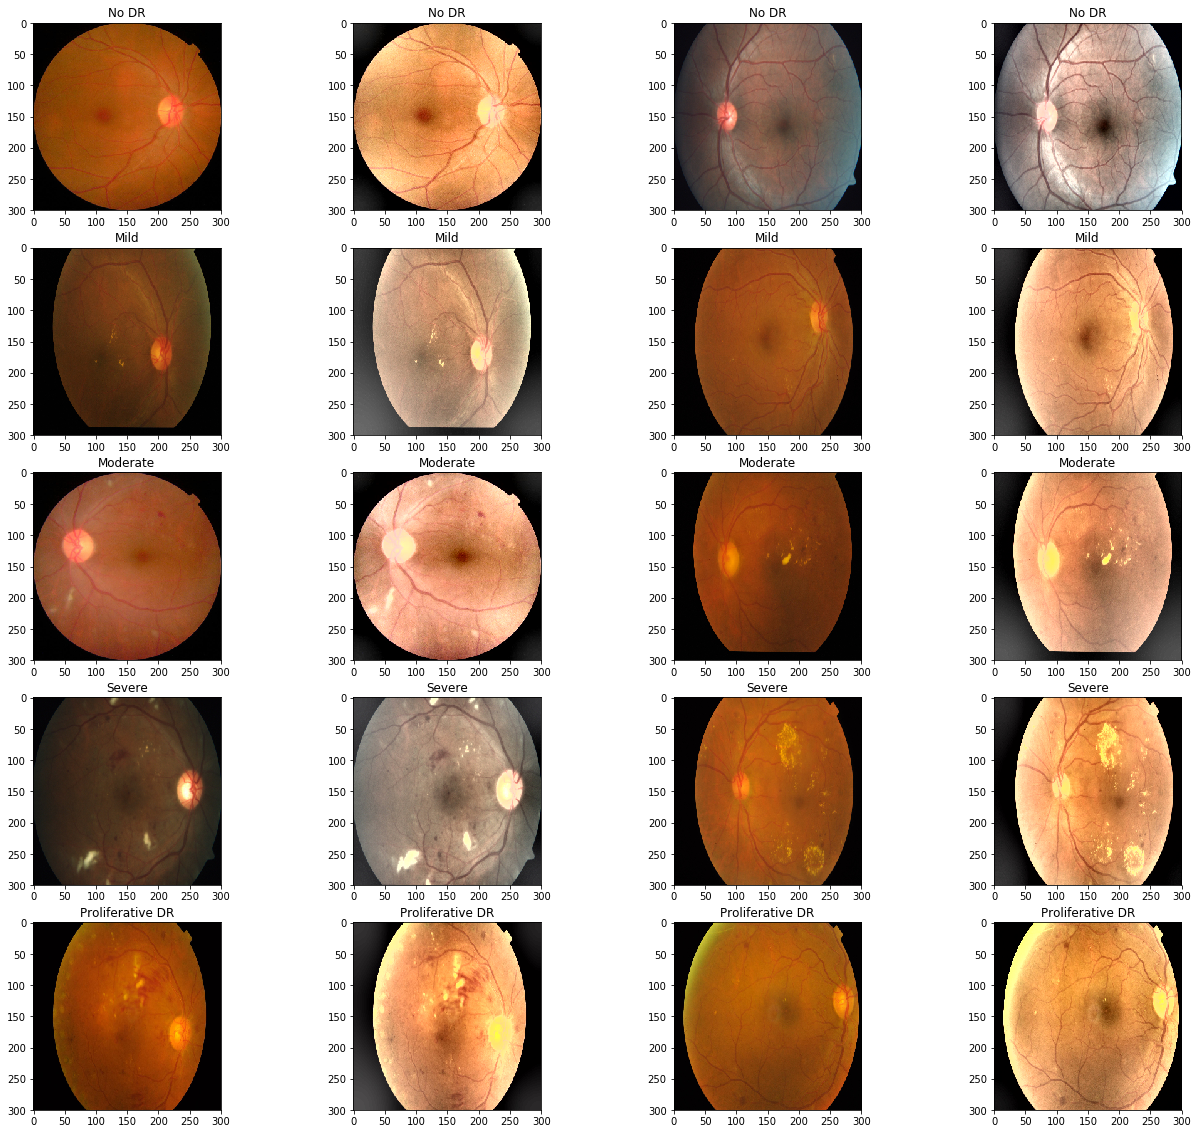

In [67]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_train['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis == target_class]
                                    .sample(2)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        
        # colored version
        funky = colourfulEyes(rgb)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])
        

In [68]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       horizontal_flip=True, 
                                       vertical_flip=True,
                                       rotation_range=20,
                                       width_shift_range=jitter,
                                       height_shift_range=jitter,
                                       shear_range=jitter,
                                       zoom_range=[(1-jitter)*ZOOM, (1+jitter)*ZOOM],
                                       fill_mode="reflect",
                                       preprocessing_function=colourfulEyes
                                      )
    return datagen

# 2019
def generators2019(jitter):
    
    datagen = dataGenerator(jitter)
    train_gen = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory="../aptos2019/train_images/",
                                              x_col="id_code",
                                              class_mode="raw",
                                              y_col=["0", "1", "2", "3", "4"],
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_DIM, IMG_DIM),
                                              subset='training', 
                                              interpolation="bilinear",
                                              seed=SEED,
                                              shuffle = True,
                                             )
    valid_gen = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory="../aptos2019/train_images/",
                                              x_col="id_code",
                                              class_mode="raw",
                                              y_col=["0", "1", "2", "3", "4"],
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_DIM, IMG_DIM),
                                              subset='validation',
                                              interpolation="bilinear",
                                              seed=SEED,
                                              shuffle = True,
                                             )
    return train_gen, valid_gen

train_generator, valid_generator = generators2019(jitter=0.05)


# 2015
def generators2015(jitter):
    
    datagen = dataGenerator(jitter)
    
    train_gen = datagen.flow_from_dataframe(dataframe=df_train_2015,
                                                      directory="../aptos2015/train_images/",
                                                      x_col="image",
                                                      class_mode="raw",
                                                      y_col=["0", "1", "2", "3", "4"],
                                                      batch_size=BATCH_SIZE,
                                                      target_size=(IMG_DIM, IMG_DIM),
                                                      subset='training',
                                                      interpolation="bilinear",
                                                      seed=SEED,
                                                      shuffle = True,
                                                     )
    valid_gen = datagen.flow_from_dataframe(dataframe=df_train_2015,
                                                      directory="../aptos2015/train_images/",
                                                      x_col="image",
                                                      class_mode="raw",
                                                      y_col=["0", "1", "2", "3", "4"],
                                                      batch_size=BATCH_SIZE,
                                                      target_size=(IMG_DIM, IMG_DIM),
                                                      subset='validation',
                                                      interpolation="bilinear",
                                                      seed=SEED,
                                                      shuffle = True,
                                                     )
    return train_gen, valid_gen

gc.collect()


Found 1571 validated image filenames.
Found 392 validated image filenames.


51561

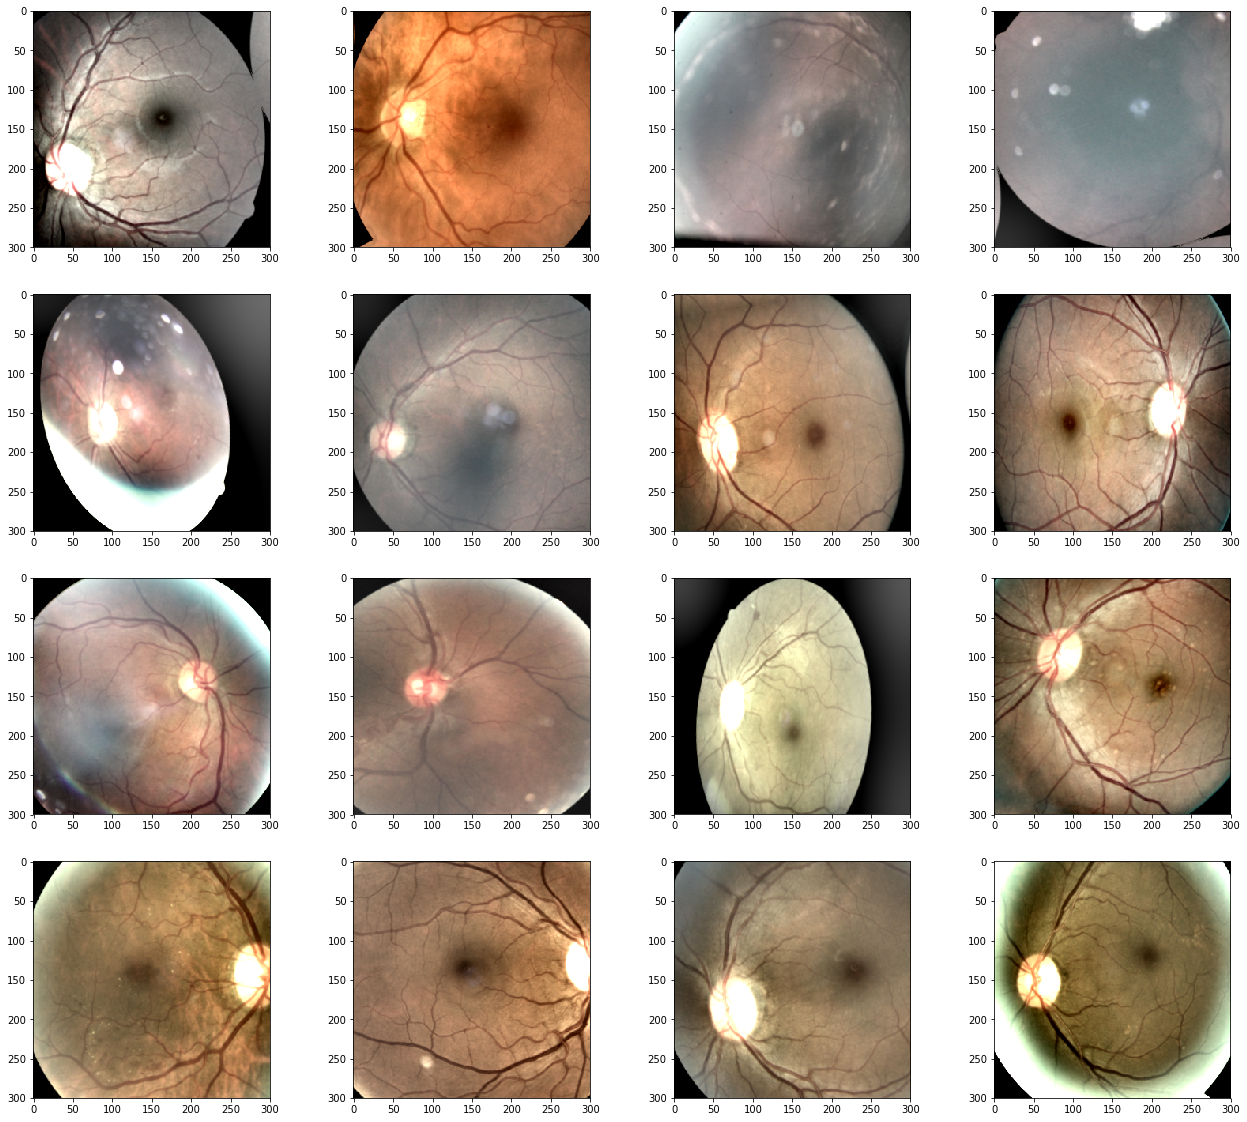

In [46]:
# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_generator_2015:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [48]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        for X_val, y_val in valid_generator:
            y_val= np.argmax(y_val, axis=1)
            preds = model_resnet.predict(X_val)
            print(y_val[:5], preds[:5])
            y_pred = np.argmax(preds,axis=1)

            val_kappa = cohen_kappa_score(
                y_val,
                y_pred, 
                weights='quadratic'
            )

            self.val_kappas.append(val_kappa)

            print(f"val_kappa: {val_kappa:.4f}")

            if val_kappa == max(self.val_kappas):
                print("Max of this run, saving model.")
                model_resnet.save(f"resnet-{val_kappa:.4f}.h5")
            break

# Call backs during training            
kappa_callbacks = Metrics()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                               min_lr=1e-6, mode='auto', verbose=1)

NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUM_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUM_TRAIN_STEPS, NUM_VALID_STEPS


(65, 16)

In [11]:
def create_resnet(img_dim, CHANNELS, n_class):
    input_tensor=Input(shape=(img_dim, img_dim, CHANNELS))
  
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../resnet50/base.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = Dense(512,  activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)
    
    return model_resnet

model_resnet=create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


W0811 00:57:52.937886 140393394054912 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 00:57:52.938965 140393394054912 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 00:57:52.946868 140393394054912 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0811 00:57:52.987262 140393394054912 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py

In [69]:
# todo: don't think this is thinking of frozen layers
for layers in model_resnet.layers:
    layers.trainable = True

# model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
model_resnet.compile(optimizer=Adam(), loss=keras.losses.mean_squared_error,  metrics=['accuracy'])
# model_resnet.summary()
gc.collect()

0

In [ ]:
# train the model for 12 epochs
history = model_resnet.fit_generator(generator=train_generator,
                                      steps_per_epoch=NUM_TRAIN_STEPS,
                                      validation_data=valid_generator,
                                      validation_steps=NUM_VALID_STEPS,
                                      epochs=12,
                                      callbacks=[early_stop, reduce_lr, kappa_callbacks],
                                      verbose=1
                                     )
gc.collect()

Epoch 1/12
18/65 [=======>......................] - ETA: 4:24 - loss: 0.0901 - acc: 0.3472

In [53]:
# train on 2015 stuff
# model_resnet.load_weights("resnet-0.3283.h5")
train_gen_2015, valid_gen_2015 = generators2015(jitter=0.05)
history = model_resnet.fit_generator(generator=train_gen_2015,
                                      steps_per_epoch=NUM_TRAIN_STEPS,
                                      validation_data=valid_gen_2015,
                                      validation_steps=NUM_VALID_STEPS,
                                      epochs=12,
                                      callbacks=[early_stop, reduce_lr, kappa_callbacks],
                                      verbose=1
                                     )
gc.collect()

Found 6620 validated image filenames.
Found 1654 validated image filenames.
Epoch 1/12
65/65 [==============================] - 347s 5s/step - loss: 0.0929 - acc: 0.2949 - val_loss: 0.2211 - val_acc: 0.2943
[2 3 4 4 0] [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
val_kappa: 0.0000
Max of this run, saving model.
Epoch 2/12
65/65 [==============================] - 310s 5s/step - loss: 0.0904 - acc: 0.2917 - val_loss: 0.1773 - val_acc: 0.3698
[3 1 1 3 3] [[9.9942696e-01 5.3846510e-04 1.5606552e-07 1.2294905e-06 3.3108499e-05]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
val_kappa: 0.0000
Max of this run, saving model.
Epoch 3/12
65/65 [==============================] - 311s 5s/step - loss: 0.0891 - a

KeyboardInterrupt: 

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy)=tqdm(model_resnet.evaluate_generator(generator=valid_generator,steps=NUM_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 


# as it was, with the eye colouring
# [INFO] accuracy: 84.71%
# [INFO] Loss: 0.45822140898023334

In [ ]:
# test_datagen = image.ImageDataGenerator(rescale=1./255,
#                                         horizontal_flip=True
#                                        )

# test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
#                                                   directory = "../aptos2019/test_images/",
#                                                   x_col="id_code",
#                                                   target_size=(IMG_DIM, IMG_DIM),
#                                                   batch_size=1,
#                                                   shuffle=False, 
#                                                   class_mode=None, 
#                                                   interpolation="bilinear",
#                                                   seed=SEED
#                                                  )

# del df_test
print(df_test.shape[0])
gc.collect()

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1./255,
                                        zoom_range=[ZOOM, ZOOM],
                                        preprocessing_function=colourfulEyes
                                       )

test_generator = test_datagen.flow_from_dataframe(dataframe = df_train,
                                                  directory = "../aptos2019/train_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False, 
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )
preds = model_resnet.predict_generator(generator=test_generator, steps=50)
preds, df_train